In [1]:
%%capture
!pip install scikit-learn==1.3.1

In [20]:
# Libraries for dealing with files and file structures
import os
import gdown
from typing import Dict, List, Tuple

# Libraries for numerical computing and data manipulation and visualization

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from scipy.stats import uniform, randint


# Libraries for implementing machine learning
import shap
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score

# Others
import warnings
warnings.filterwarnings('ignore')
plt.style.use("ggplot")

In [4]:
# Get the folder from gdrive
%%capture
url = "https://drive.google.com/drive/folders/1cK01lrTd5G4VjNbnzJ77GSq34Yk3Lh0I?usp=sharing"
gdown.download_folder(url, remaining_ok = True)

In [33]:
# Create directory to save plots
os.makedirs("plots", exist_ok = True)

### Helper Functions

In [5]:
def load_and_preprocess_data(data_dir: str, fields_to_drop: List[str], target_column: str = 'SOC',
                             test_size: float = 0.2, random_state: int = 42) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, ColumnTransformer]:
    """
    Load and preprocess CSV data from a given directory with feature engineering
    and train-test split.

    Args:
        data_dir (str): Path to the input CSV file
        fields_to_drop (List[str]): List of fields to drop from the dataframe
        target_column (str): Name of the target variable column
        test_size (float): Proportion of dataset to include in the test split
        random_state (int): Random state for reproducibility

    Returns:
        Tuple containing:
        - train_features (np.ndarray): Transformed training features
        - test_features (np.ndarray): Transformed test features
        - train_labels (np.ndarray): Training labels
        - test_labels (np.ndarray): Test labels
        - preprocessor (ColumnTransformer): Fitted column transformer for future use
    """
    # Read the data
    df = pd.read_csv(data_dir)

    # Drop unwanted fields
    df.drop(fields_to_drop, axis = 1, inplace = True)

    # Separate features and target
    labels = df[target_column]
    features = df.drop(target_column, axis = 1)

    # Identify numerical and categorical columns
    num_cols = features.select_dtypes(exclude = ['object']).columns.tolist()
    cat_cols = features.select_dtypes(include = ['object']).columns.tolist()

    # Create train-test split
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = test_size, random_state = random_state)

    # Create preprocessing pipelines for numerical and categorical data
    numeric_transformer = Pipeline(steps = [
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline(steps = [
        ('encoder', OneHotEncoder(handle_unknown = 'ignore'))
    ])

    # Combine transformers
    preprocessor = ColumnTransformer(
        transformers = [
            ('num', numeric_transformer, num_cols),
            ('cat', categorical_transformer, cat_cols)
        ],
        remainder = 'passthrough'
    )

    # Fit and transform the training data
    train_features = preprocessor.fit_transform(x_train).toarray()

    # Transform the test data
    test_features = preprocessor.transform(x_test).toarray()

    return train_features, test_features, y_train, y_test, preprocessor

In [ ]:
# Function for printing model evaluation summary
def print_evaluation_summary(metrics_df: pd.DataFrame, best_params: Dict) -> None:
    """
    Print a formatted summary of model evaluation results.

    Args:
        metrics_df: DataFrame containing model metrics
        best_params: Dictionary of best parameters for each model
    """
    print("\n=== Model Evaluation Summary ===")
    print("\nModel Performance Metrics:")
    print(metrics_df.to_string(index=False))

    print("\nBest Parameters for Each Model:")
    for model_name, params in best_params.items():
        print(f"\n{model_name}:")
        for param, value in params.items():
            print(f"  {param}: {value}")

In [41]:
# Function for analyzing feature importance using SHAP values
def analyze_feature_importance(shap_values: Dict, feature_names: List[str], X_test: np.ndarray) -> pd.DataFrame:
    """
    Analyze feature importance using SHAP values across all models.

    Args:
        shap_values: Dictionary of SHAP values for each model
        feature_names: List of feature names
        X_test: Test features


    Returns:
        DataFrame with feature importance summary
    """
    feature_importance = pd.DataFrame()

    for model_name, values in shap_values.items():
        # Calculate mean absolute SHAP values for each feature
        mean_abs_shap = np.abs(values).mean(axis=0)

        # Create a DataFrame for this model's feature importance
        model_importance = pd.DataFrame({
            'Feature': feature_names,
            f'{model_name}_Importance': mean_abs_shap
        })

        if feature_importance.empty:
            feature_importance = model_importance
        else:
            feature_importance = feature_importance.merge(
                model_importance,
                on='Feature'
            )

    # Calculate mean importance across all models
    importance_cols = [col for col in feature_importance.columns if 'Importance' in col]
    feature_importance['Mean_Importance'] = feature_importance[importance_cols].mean(axis = 1)

    # Sort by mean importance
    feature_importance = feature_importance.sort_values('Mean_Importance', ascending = False)

    return feature_importance

# Function for plotting SHAP summary plot
def plot_shap_summary(shap_values: Dict, X_test_df: pd.DataFrame, model_name: str, save_dir: str) -> None:
    """
    Plot SHAP summary plot for a specific model.

    Args:
        shap_values: Dictionary of SHAP values
        X_test_df: Test features DataFrame
        model_name: Name of the model to plot
        save_dir: Directory to save SHAP summary plots

    Returns:
        None
    """
    shap.summary_plot(
        shap_values[model_name],
        X_test_df,
        plot_type = "bar",
        show = False,
        plot_size = (10, 8)
    )

    # Add title
    plt.title(f'SHAP Feature Importance - {model_name}')

    # Save figure
    plt.savefig(f'{save_dir}/{model_name}_shap_summary.png', dpi = 430, bbox_inches = 'tight')

    plt.tight_layout()
    plt.show()

In [6]:
# Function for model training and evaluation
def evaluate_models_with_shap(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray,
                              y_test: np.ndarray, feature_names: List[str], cv_folds: int = 5, n_iter: int = 100,
                              random_state: int = 42) -> Tuple[Dict, pd.DataFrame, Dict, Dict]:
    """
    Evaluate multiple regression models using various metrics, cross-validation, and SHAP values.
    """
    # Define models with their parameter distributions for RandomizedSearchCV
    models = {
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'RandomForest': {
            'model': RandomForestRegressor(random_state=random_state),
            'params': {
                'n_estimators': randint(50, 300),
                'max_depth': [None] + list(range(5, 31)),
                'min_samples_split': randint(2, 11),
                'min_samples_leaf': randint(1, 5)
            }
        },
        'XGBoost': {
            'model': XGBRegressor(
                random_state=random_state,
                use_label_encoder = False,
                eval_metric='rmse'
            ),
            'params': {
                'n_estimators': randint(50, 300),
                'max_depth': randint(3, 10),
                'learning_rate': uniform(0.01, 0.3),
                'subsample': uniform(0.6, 0.4),
                'colsample_bytree': uniform(0.6, 0.4)
            }
        },
        'SVR': {
            'model': SVR(),
            'params': {
                'C': uniform(0.1, 10),
                'epsilon': uniform(0.01, 0.1),
                'gamma': ['scale', 'auto']
            }
        }
    }

    # Initialize dictionaries to store results
    best_models = {}
    best_params = {}
    shap_values = {}
    results = []

    # Create KFold cross-validator
    kf = KFold(n_splits = cv_folds, shuffle = True, random_state = random_state)

    # Convert feature matrix to DataFrame for SHAP analysis
    X_train_df = pd.DataFrame(X_train, columns = feature_names)
    X_test_df = pd.DataFrame(X_test, columns = feature_names)

    # Evaluate each model
    for name, model_info in models.items():
        print(f"\nEvaluating {name}...")

        try:
            # Perform RandomizedSearchCV
            random_search = RandomizedSearchCV(
                model_info['model'],
                model_info['params'],
                n_iter=n_iter,
                cv=kf,
                scoring='neg_mean_squared_error',
                n_jobs=-1,
                random_state=random_state
            )

            # Fit the model
            random_search.fit(X_train, y_train)
            best_model = random_search.best_estimator_
            best_models[name] = best_model
            best_params[name] = random_search.best_params_

            # Calculate SHAP values
            try:
                if name == 'SVR':
                    explainer = shap.KernelExplainer(best_model.predict, shap.sample(X_train_df, 100))
                    shap_values[name] = explainer.shap_values(X_test_df)
                elif name == 'LinearRegression':
                    explainer = shap.LinearExplainer(best_model, X_train_df)
                    shap_values[name] = explainer.shap_values(X_test_df)
                else:
                    explainer = shap.TreeExplainer(best_model)
                    shap_values[name] = explainer.shap_values(X_test_df)
            except Exception as e:
                print(f"SHAP calculation failed for {name}: {str(e)}")
                shap_values[name] = None

            # Make predictions
            y_pred = best_model.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)

            # Perform cross-validation
            cv_scores = cross_val_score(
                best_model,
                X_train,
                y_train,
                cv=kf,
                scoring='neg_mean_squared_error'
            )
            cv_rmse = np.sqrt(-cv_scores.mean())
            cv_rmse_std = np.sqrt(-cv_scores).std()

            # Store results
            results.append({
                'Model': name,
                'RMSE': rmse,
                'MAE': mae,
                'R2 Score': r2,
                'CV RMSE': cv_rmse,
                'CV RMSE Std': cv_rmse_std
            })

        except Exception as e:
            print(f"Error evaluating {name}: {str(e)}")
            continue

    # Create DataFrame with results
    metrics_df = pd.DataFrame(results)
    metrics_df = metrics_df.sort_values('RMSE')

    return best_models, metrics_df, best_params, shap_values

# Function for analyzing feature importance using SHAP values
def analyze_feature_importance(shap_values: Dict, feature_names: List[str], X_test: np.ndarray) -> pd.DataFrame:
    """
    Analyze feature importance using SHAP values across all models.

    Args:
        shap_values: Dictionary of SHAP values for each model
        feature_names: List of feature names
        X_test: Test features

    Returns:
        DataFrame with feature importance summary
    """
    feature_importance = pd.DataFrame()

    for model_name, values in shap_values.items():
        if values is not None:
            # Calculate mean absolute SHAP values for each feature
            mean_abs_shap = np.abs(values).mean(axis=0)

            # Create a DataFrame for this model's feature importance
            model_importance = pd.DataFrame({
                'Feature': feature_names,
                f'{model_name}_Importance': mean_abs_shap
            })

            if feature_importance.empty:
                feature_importance = model_importance
            else:
                feature_importance = feature_importance.merge(
                    model_importance,
                    on='Feature'
                )

    # Calculate mean importance across all models
    importance_cols = [col for col in feature_importance.columns if 'Importance' in col]
    if importance_cols:
        feature_importance['Mean_Importance'] = feature_importance[importance_cols].mean(axis = 1)
        # Sort by mean importance
        feature_importance = feature_importance.sort_values('Mean_Importance', ascending = False)

    return feature_importance

In [25]:
def plot_regression_predictions(models: Dict, X_test: np.ndarray, y_test: np.ndarray,
                              feature_names: List[str]) -> None:
    """
    Create regression plots comparing predicted vs actual values for multiple models.
    """

    # Set up the subplot grid based on number of models
    n_models = len(models)
    n_cols = 2
    n_rows = (n_models + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 5*n_rows))
    axes = axes.flatten()

    for idx, (name, model) in enumerate(models.items()):
        # Get predictions
        y_pred = model.predict(X_test)

        # Calculate r2
        r2 = r2_score(y_test, y_pred)

        # Create scatter plot
        sns.scatterplot(x = y_test, y = y_pred, alpha = 0.5, ax = axes[idx])

        # Add perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', label = 'Perfect Prediction')

        # Add regression line
        sns.regplot(x = y_test, y = y_pred, scatter = False, color = 'blue',
                   ax = axes[idx], label='Regression Line')

        # Customize plot
        axes[idx].set_title(f'{name}\nR\u00B2: {r2:.3f}')
        axes[idx].set_xlabel('Actual Values')
        axes[idx].set_ylabel('Predicted Values')
        axes[idx].legend()

    # Remove any empty subplots
    for idx in range(len(models), len(axes)):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()

In [26]:
def save_regression_plots(models: Dict, X_test: np.ndarray, y_test: np.ndarray,
                         save_dir: str = './plots', format: str = 'png') -> None:
    """
    Create and save individual regression plots for each model.
    """

    os.makedirs(save_dir, exist_ok=True)

    for name, model in models.items():
        plt.figure(figsize = (10, 8))

        # Get predictions and R2
        y_pred = model.predict(X_test)
        r2 = r2_score(y_test, y_pred)

        # Create scatter plot with regression line
        sns.scatterplot(x = y_test, y = y_pred, alpha = 0.5)
        sns.regplot(x = y_test, y = y_pred, scatter = False, color = 'blue', label = 'Regression Line')

        # Add perfect prediction line
        min_val = min(y_test.min(), y_pred.min())
        max_val = max(y_test.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--', label = 'Perfect Prediction')

        plt.title(f'{name} Regression Plot\nR\u00B2: {r2:.3f}')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()

        # Save plot
        filename = os.path.join(save_dir, f'regression_plot_{name}.{format}')
        plt.savefig(filename, dpi = 300, bbox_inches = 'tight')
        plt.close()

### Data Preparation

In [7]:
# Set the data path
data_dir = "/content/csv/merged_v3_enriched.csv"

In [8]:
# List the fields to drop
fields_to_drop = ['Area', 'Boron', 'Zinc', 'longitude', 'latitude']
train_features, test_features, train_labels, test_labels, preprocessor = load_and_preprocess_data(data_dir, fields_to_drop)

### Model Training and Evaluation

In [9]:
# Get feature names
feature_names = preprocessor.get_feature_names_out()

In [10]:
# Get rid of the prefixes (num__ and cat__) from the feature names
feature_names = [name.split("__")[-1] for name in feature_names]
# feature_names

In [11]:
# Train and evaluate models
best_models, metrics_df, best_params, shap_values = evaluate_models_with_shap(train_features, test_features, train_labels, test_labels, feature_names)


Evaluating LinearRegression...

Evaluating RandomForest...

Evaluating XGBoost...

Evaluating SVR...


  0%|          | 0/517 [00:00<?, ?it/s]

In [13]:
# Analyze feature importance across all models
feature_importance_df = analyze_feature_importance(shap_values, feature_names, test_features)

In [ ]:
# Print feature importance summary
print("\nFeature Importance Summary:")
print(feature_importance_df)

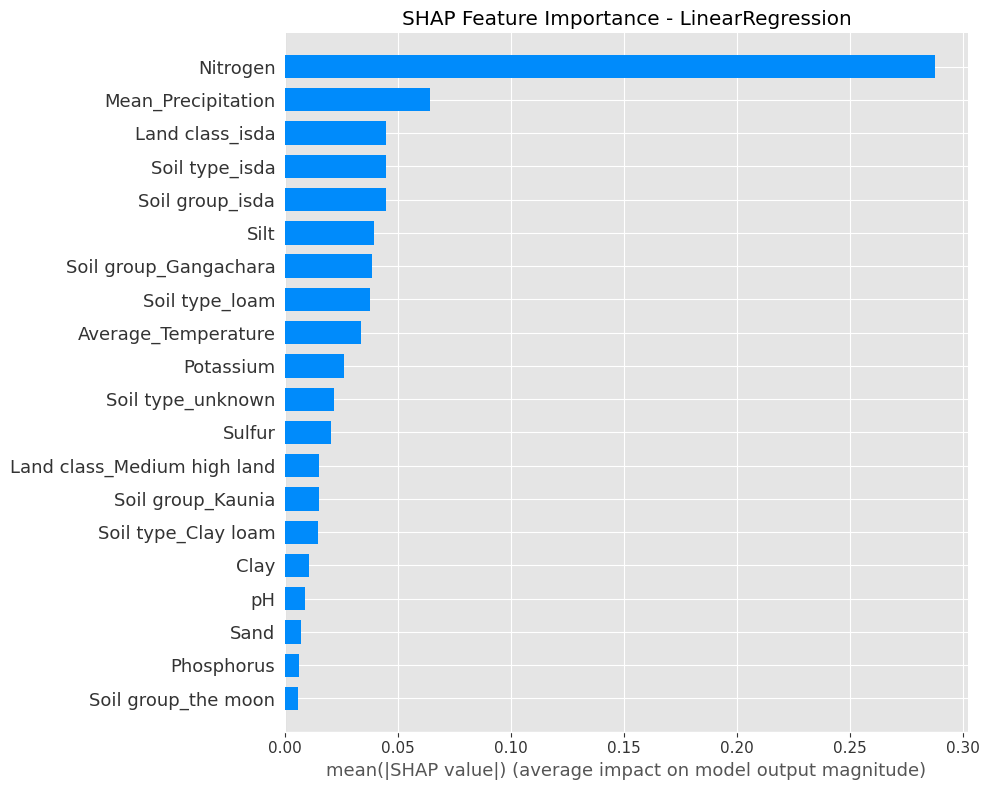

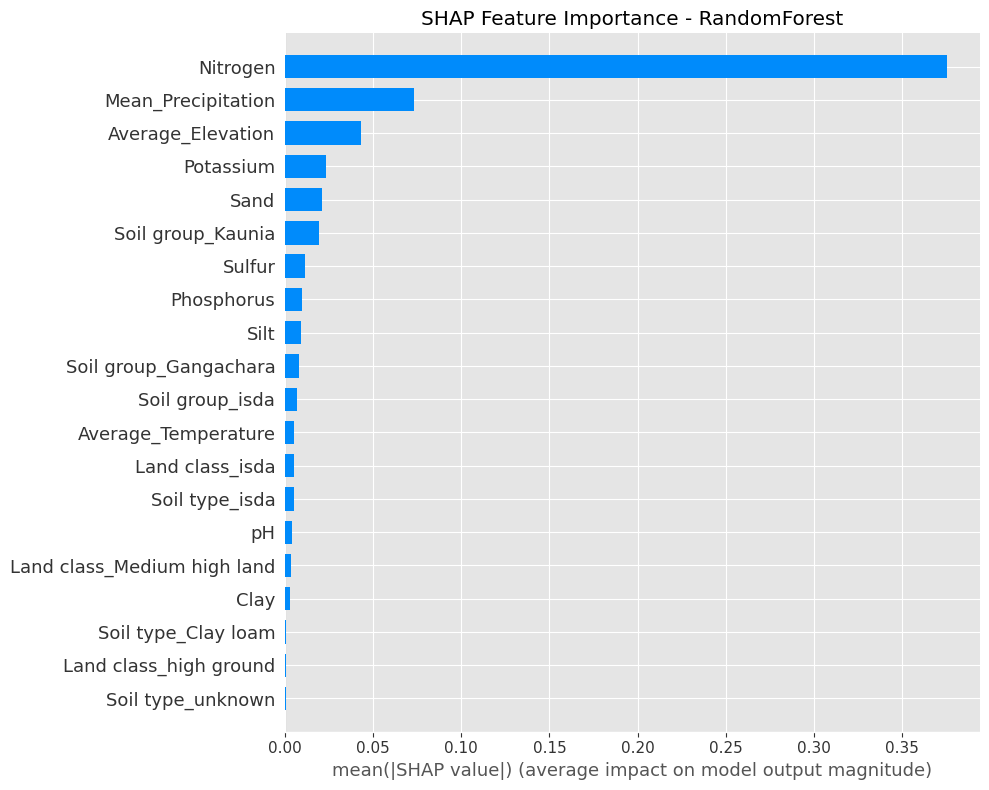

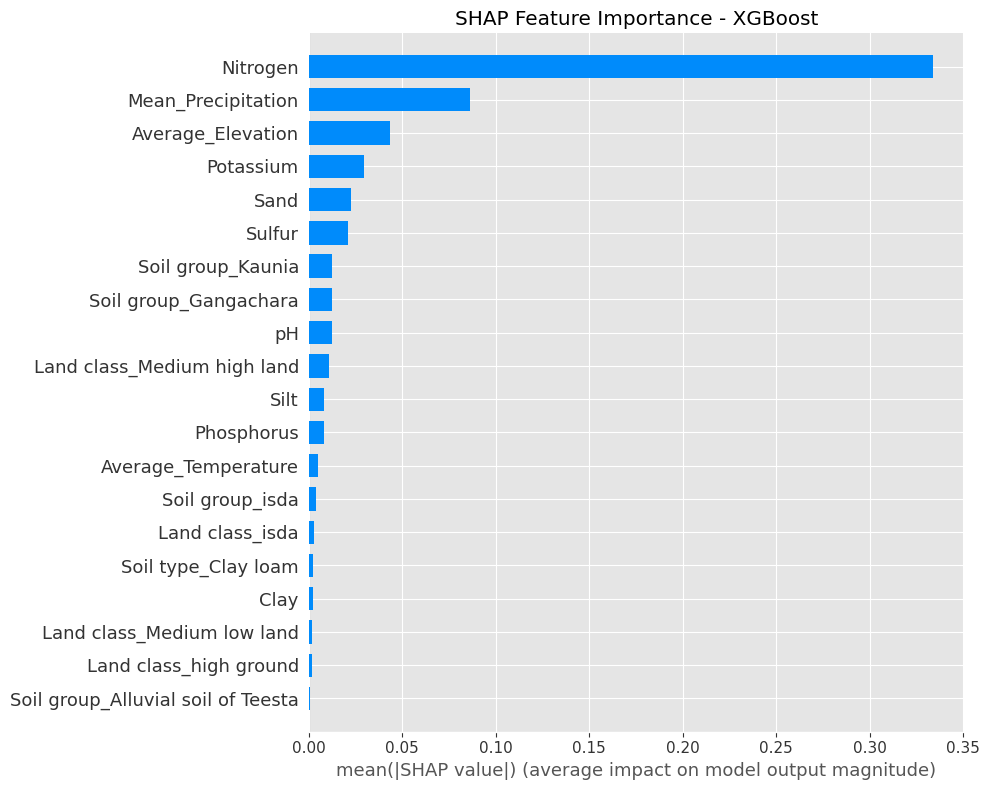

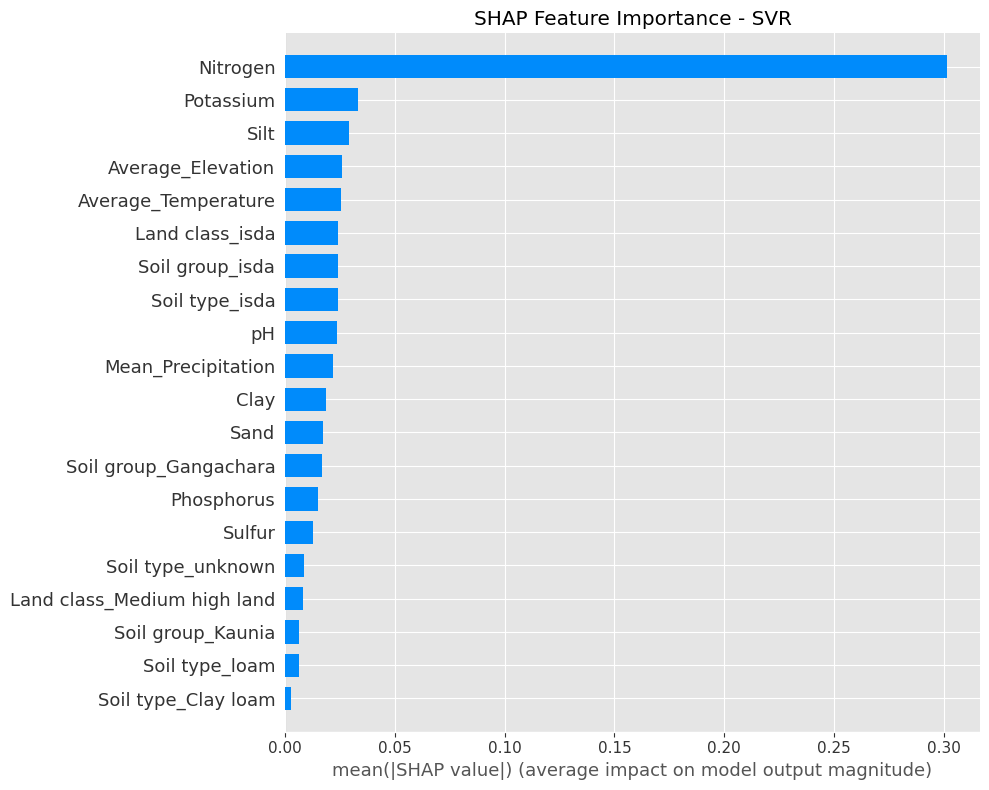

In [42]:
# Plot shap summary plot for each model
save_dir = './plots'
for model_name in best_models.keys():
    plot_shap_summary(shap_values, pd.DataFrame(test_features, columns = feature_names), model_name, save_dir = save_dir)

In [18]:
# View the performance of each model
metrics_df.head()

,Model,RMSE,MAE,R2 Score,CV RMSE,CV RMSE Std
1,RandomForest,0.254917,0.168785,0.825433,0.265363,0.015952
2,XGBoost,0.257968,0.173745,0.821230,0.267518,0.013767
3,SVR,0.262604,0.172951,0.814746,0.272334,0.014795
0,LinearRegression,0.272831,0.182821,0.800036,0.267765,0.015321


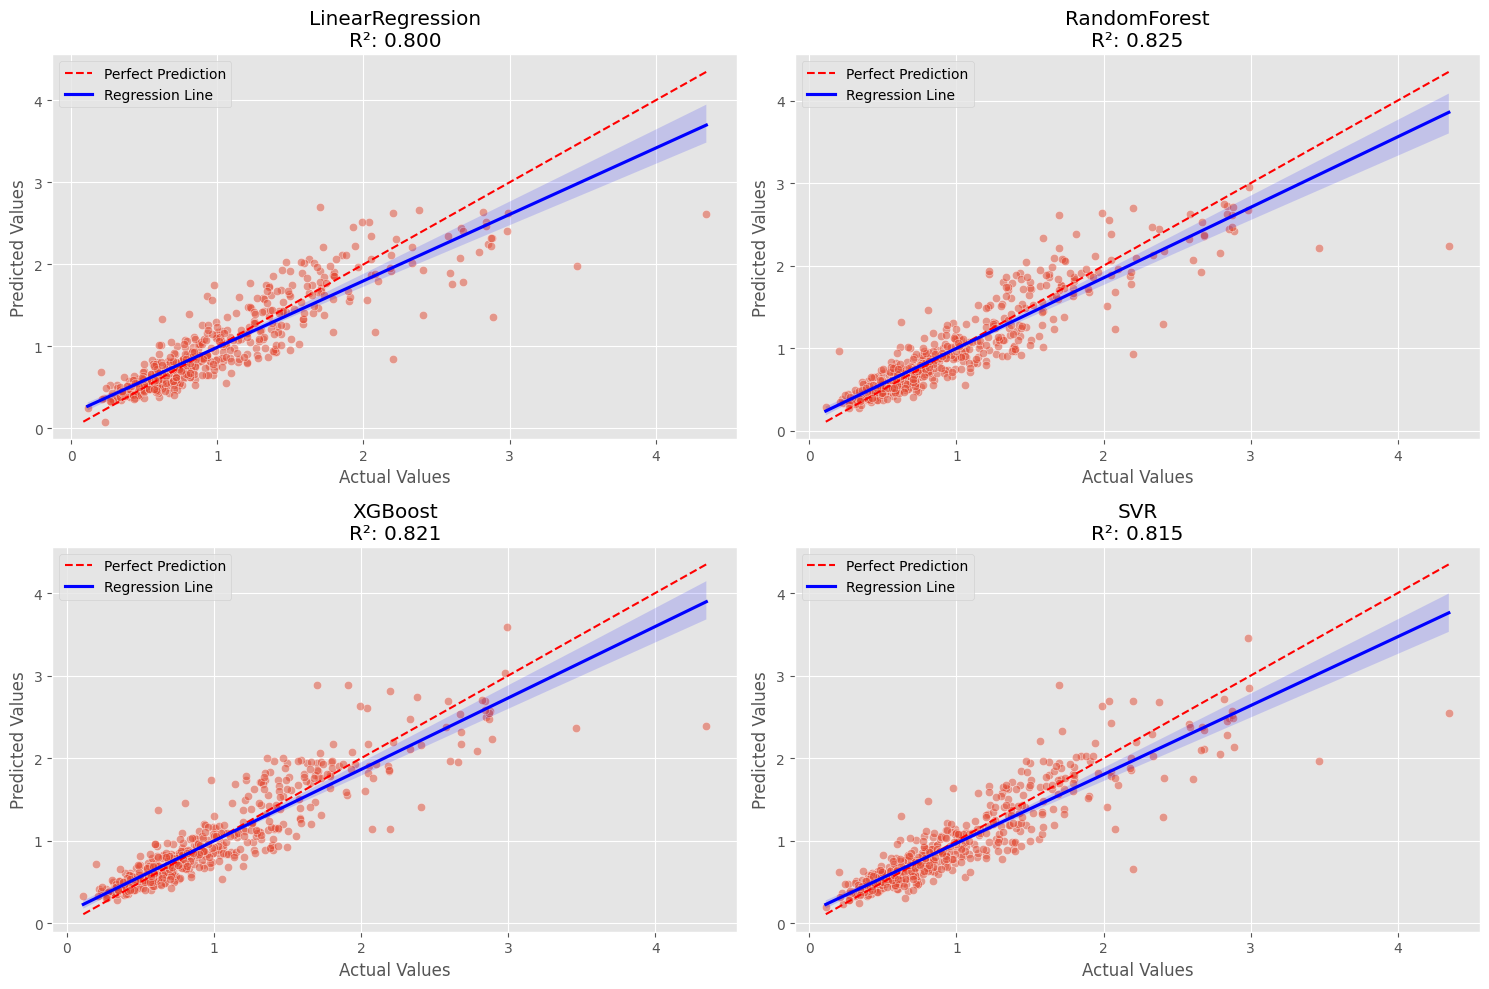

In [27]:
# Plot regression plots for each model
plot_regression_predictions(best_models, test_features, test_labels, feature_names)

In [40]:
# Save the plots
save_regression_plots(best_models, test_features, test_labels, save_dir = save_dir)